In [1]:
import lmfit as lm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Parameters, Minimizer
from get_data import get_weather_data, get_dengue_data, plot_data
from edo_model_yang import C0, A0, R_m
from edo_model_yang import sup_cap_yang, system_odes, solve_model,get_temp, solve_fit, plot_fit

Neste notebook é realizado o fitting do modelo considerados três situações diferentes:

- Fitando b, beta e c (valor q será multiplicado por 10^4 e irá representar a capacidade suporte) para o modelo com parâmetros ontomológicos constantes. 

- Fitando b, beta e c (valor q será multiplicado por 10^4 e irá representar a capacidade suporte) para o modelo com parâmetros ontomológicos variando pela temperatura. 

- Fitando b e beta para o modelo com parâmetros ontomológicos variando pela temperatura e a capacidade suporte definida pela fórmula do Yang 2016, que varia com os dados de precipitação. 

No texto acima: 
- b: average bite per mosquito per day. 
- beta: Vai representar beta_m e beta_h, que são as taxas de contato efetivas e por hipótese serão consideradas iguas. 


Capturando os dados de dengue:

In [2]:
df = get_dengue_data()
df

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-07,1.571429,0.857143,0.285714,1.571429
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000
...,...,...,...,...
2022-08-26,14.428571,13.000000,0.000000,105604.285714
2022-08-27,14.714286,13.428571,0.000000,105619.000000
2022-08-28,13.571429,12.285714,0.000000,105632.571429


In [3]:
df_2010 = df.loc[ (df.index >= '2010-01-08')  &  (df.index <= '2010-06-30')]

df_2010.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000
2010-01-12,2.428571,1.285714,0.571429,11.428571


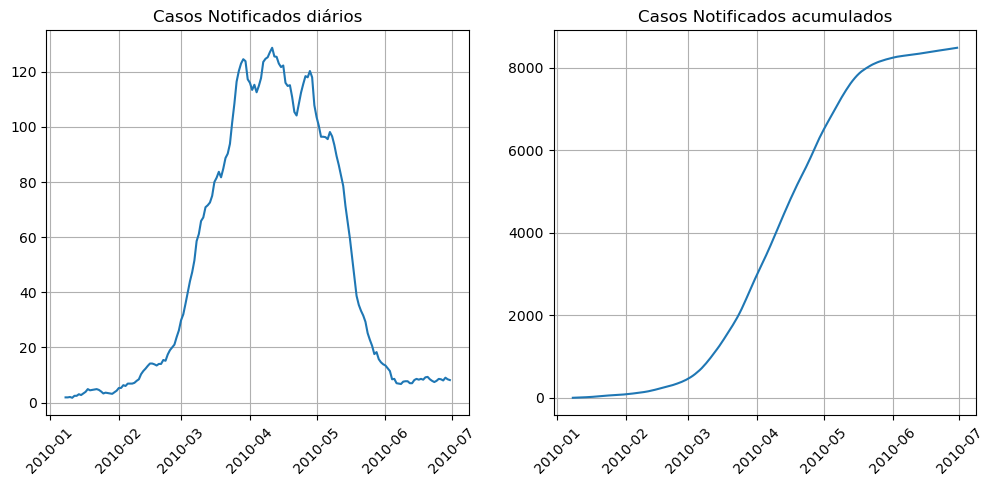

In [4]:
plot_data(df_2010)

Fitting com os parâmetros fixos:

In [5]:
def fun_obj_fix(params,t, data, r0): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """


    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()

    b = pars['b']
    beta = pars['beta']
    c = pars['c']
  
    parametros = b, beta
    
    # parâmetros fixos 
    MU_H = 1/(365*67)    #human mortality rate - day^-1
    ALPHA_H = 0.1 #recovering rate - day^-1
    THETA_H = 0.027   #intrinsic incubation rate - day^-1
    K = 0.5          #fraction of female mosquitoes hatched from all egs
    C_A = 0.0      #control effort rate on aquatic phase
    C_M = 0.0    #control effort rate on terretrial phase
    D = 4 


    par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M, D

    # Aqui é solucionado o sistema 
    r = solve_model(t, r0, parametros, par_fixed, None, c, fixed = True)
    
    Hi = r.y[6]
    Hr = r.y[7]

    model = Hi+ Hr 

    res = model - data
    
    return res  

Parâmetros: 

In [6]:
# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()


params.add('b', min = 0.001, max = 1, vary = True)
params.add('beta', min = 0.001, max = 1, vary = True)
params.add('c', min = 0.5, max = 50, vary = True)

data = df_2010.acum_notified

dias = np.arange(0, len(data), 1)

In [7]:
T = get_temp(start_date = '2010-01-08', end_date = '2010-06-30')

print(T[0])

28.0


In [10]:
# população de Foz (censo 2010)
N = 256088

# assumindo que há 2 mosquitos para cada habitante da cidade
Ms_0 = 2*N


# para T = 28
k = 0.5
delta = 8.39
gamma_m = 0.12
mu_a = 0.06848
mu_m = 0.03039
c_m = 0.0


A_0 = A0(Ms_0, gamma_m, mu_m, c_m)

C_0 = C0(Ms_0,k,delta,gamma_m, mu_m,mu_a, c_m = 0, c_a = 0)

print("A0:", A_0)
print("C_0:", C_0)

A0: 129708.57200000001
C_0: 131201.43984251955


Condições iniciais: 

In [11]:


# A, Ms, Me, Mi, Hs, He, Hi, Hr 
Hi0 = 2
Mi0 = 0
r0 = [ A_0, 2*N - Mi0, 0, Mi0, N - Hi0 , 0, Hi0, 0]


Aplicando o fitting:

In [12]:
%%time

out = lm.minimize(fun_obj_fix, params, args = (dias, data, r0), method = 'leastq')
lm.report_fit(out)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 449
    # data points      = 174
    # variables        = 3
    chi-square         = 4.3108e+08
    reduced chi-square = 2520931.87
    Akaike info crit   = 2567.75805
    Bayesian info crit = 2577.23522
[[Variables]]
    b:     0.99986191 +/- 1.78284840 (178.31%) (init = 0.001)
    beta:  0.71082786 +/- 1.26747580 (178.31%) (init = 0.001)
    c:     0.50000000 +/- 2.4776e-08 (0.00%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, beta) = -1.000
CPU times: user 24.4 s, sys: 80.8 ms, total: 24.4 s
Wall time: 24.5 s


Plotando a saída do modelo fitado:

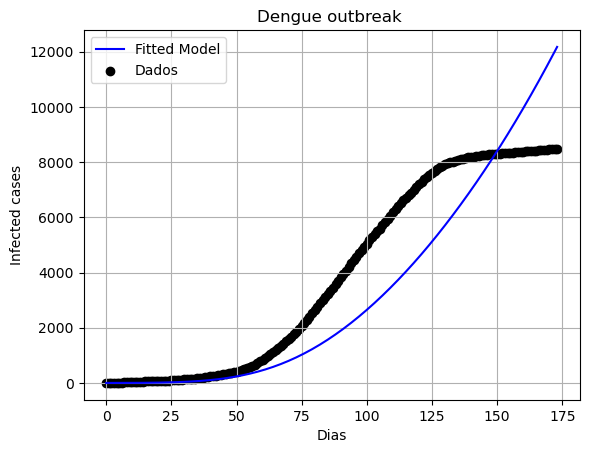

In [14]:
pars = out.params
pars = pars.valuesdict()

H_fit = solve_fit(out, dias, y0 = r0, temp = None, fixed = True )

plot_fit(dias, data, H_fit)

Fitting com os parâmetros ontomológicos variando no tempo:

In [15]:
def fun_obj_var_onto(params,t, data, r0 = [1000, 0, 21, 0], T = None): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """

    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()

    b = pars['b']
    beta = pars['beta']
    c = pars['c']
    
    parametros = b, beta
    
    # parâmetros fixos 
    MU_H = 1/(365*67)    #human mortality rate - day^-1
    ALPHA_H = 0.1 #recovering rate - day^-1
    THETA_H = 0.027   #intrinsic incubation rate - day^-1
    K = 0.5          #fraction of female mosquitoes hatched from all egs
    C_A = 0.0      #control effort rate on aquatic phase
    C_M = 0.0    #control effort rate on terretrial phase
    D = 4 

    par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M, D

    # Aqui é solucionado o sistema 
    r = solve_model(t, r0, parametros, par_fixed, T, c, fixed = False)
    
    Hi = r.y[6]
    Hr = r.y[7]

    model = Hi+ Hr 

    #res = (Hi - data)/np.sqrt(Hi+1)
    res = model - data 
    
    return res  

In [16]:
%%time

out = lm.minimize(fun_obj_var_onto, params, args = (dias, data, r0, T), method = 'leastq')

lm.report_fit(out)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 791
    # data points      = 174
    # variables        = 3
    chi-square         = 5.5474e+08
    reduced chi-square = 3244120.06
    Akaike info crit   = 2611.64355
    Bayesian info crit = 2621.12072
[[Variables]]
    b:     0.51496687 +/- 6.6679e-05 (0.01%) (init = 0.001)
    beta:  0.90128626 +/- 3.9827e-05 (0.00%) (init = 0.001)
    c:     0.50844378 +/- 1.0779e-04 (0.02%) (init = 0.5)
CPU times: user 2min 22s, sys: 234 ms, total: 2min 23s
Wall time: 2min 23s


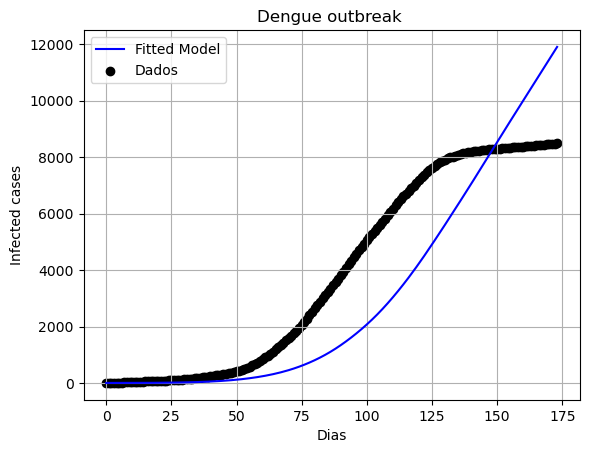

In [18]:
pars = out.params
pars = pars.valuesdict()

H_fit_onto = solve_fit(out, dias, y0 = r0, temp = T, fixed = False)

plot_fit(dias, data, H_fit_onto)

Fitting do modelo fixando a capacidade suporte do yang: 

In [26]:
def fun_obj_var_onto_cap(params,t, data, r0, T = None, df_we = None): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """


    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()

    b = pars['b']
    beta = pars['beta']
    
    parametros = b, beta
    
    
    # parâmetros fixos 
    MU_H = 1/(365*67)    #human mortality rate - day^-1
    ALPHA_H = 0.1 #recovering rate - day^-1
    THETA_H = 0.027   #intrinsic incubation rate - day^-1
    K = 0.5          #fraction of female mosquitoes hatched from all egs
    C_A = 0.0      #control effort rate on aquatic phase
    C_M = 0.0    #control effort rate on terretrial phase
    D = 4 

    par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M, D
    
    c = sup_cap_yang(df_we)

    # Aqui é solucionado o sistema 
    r = solve_model(t, r0, parametros, par_fixed, T, c, fixed = False)
    
    Hi = r.y[6]
    Hr = r.y[7]

    model = Hi+ Hr 

    res = model - data 
    
    return res  

In [27]:
df_we = get_weather_data()
df_we = df_we.loc[(df_we.index >= '2010-01-01') & (df_we.index <= '2010-06-30')] 


In [31]:
%%time

# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()


params.add('b', min = 0.001, max = 1, vary = True)
params.add('beta', min = 0.001, max = 1, vary = True)

out = lm.minimize(fun_obj_var_onto_cap, params, args = (dias, data, r0, T, df_we), method = 'leastq')

lm.report_fit(out)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 242
    # data points      = 174
    # variables        = 2
    chi-square         = 5.4531e+08
    reduced chi-square = 3170397.04
    Akaike info crit   = 2606.65834
    Bayesian info crit = 2612.97645
##  Warning: uncertainties could not be estimated:
[[Variables]]
    b:     0.66875802 (init = 0.001)
    beta:  0.69134879 (init = 0.001)
CPU times: user 2min 56s, sys: 244 ms, total: 2min 56s
Wall time: 2min 56s


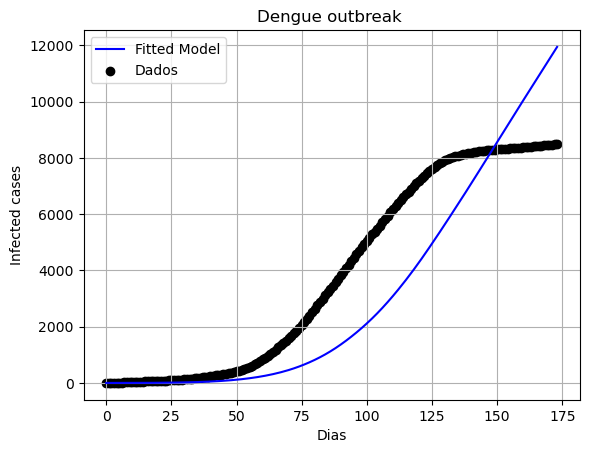

In [32]:
pars = out.params
pars = pars.valuesdict()

H_fit_onto_cap = solve_fit(out, dias, r0, temp = T, df_we = df_we, fixed = False)

plot_fit(dias, data, H_fit_onto_cap)


Comparando as estratégias de fitting:

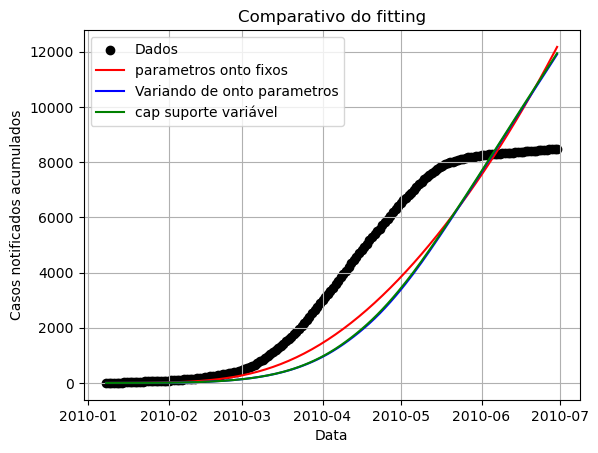

In [33]:
fig, ax = plt.subplots()
 
ax.scatter(data.index, data.values,color='black',label='Dados')

ax.plot(data.index, H_fit, color='red',label='parametros onto fixos')

ax.plot(data.index, H_fit_onto, color='blue',label='Variando de onto parametros')

ax.plot(data.index, H_fit_onto_cap, color='green',label='cap suporte variável')
    
#Set the labels
ax.set_ylabel('Casos notificados acumulados')
ax.set_xlabel('Data')

#Create a grid for visualization
ax.grid()

#Set the title
ax.set_title('Comparativo do fitting')
#The size of the numbers on the axixis

plt.legend()
plt.show()

Fitting dos parâmetros relacionados com a capacidade suporte: